In [28]:
import pathlib as path
import yaml
import matplotlib.pyplot as plt
import pandas as pd
import sys
import numpy as np
from scipy.signal import welch

In [29]:
sys.path.append('../common_eurobench')
from conversion import convert_utils as conv

In [71]:
subjects = [1]
sf = 2048
cond = 'without' #with or whithout (exo)
folder = 'SUBJECT_0X/SESSION_01/IRREGULAR_TERRAIN/EMG'

In [73]:
# Change the path of your data
path_data = '/Users/neuralrehabilitationgroup/PycharmProjects/DATA_ExoStim/DATA/gait_' + cond + '_exo'

In [74]:
path_raw = path.Path(path_data).joinpath('EUROBENCH',folder)
path_gait_filt = path.Path(path_data).joinpath('PROCESSED',folder,'FILTERED')
path_gait_clean = path.Path(path_data).joinpath('PROCESSED',folder,'CLEANED')
path_events = path.Path(path_data).joinpath('EUROBENCH', folder)
path_gait_env = path.Path(path_data).joinpath('PROCESSED',folder,'ENVELOPE')

# Plot EMG signals (filtered or cleaned)

In [75]:
# For filtered signals:
# path_signal = path_gait_filt
# For cleaned signals:
path_signal = path_gait_clean

SUBJECT 01
Processing file subject_01_cond_01_run_01_cleaned.csv
***File /Users/neuralrehabilitationgroup/PycharmProjects/DATA_ExoStim/DATA/gait_without_exo/EUROBENCH/SUBJECT_0X/SESSION_01/IRREGULAR_TERRAIN/EMG/subject_01_Info.yaml not found***
dict_keys(['ErSp_l', 'ReFe_l', 'BiFe_l', 'ReAb_r', 'GaLa_r', 'GaLa_l', 'GlMe_l', 'time', 'ErSp_r', 'TiAn_r', 'ReFe_r', 'ReAb_l', 'TiAn_l', 'GlMe_r', 'BiFe_r'])
Processing file subject_01_cond_01_run_01_cleaned.csv
***File /Users/neuralrehabilitationgroup/PycharmProjects/DATA_ExoStim/DATA/gait_without_exo/EUROBENCH/SUBJECT_0X/SESSION_01/IRREGULAR_TERRAIN/EMG/subject_01_Info.yaml not found***
dict_keys(['ErSp_l', 'ReFe_l', 'BiFe_l', 'ReAb_r', 'GaLa_r', 'GaLa_l', 'GlMe_l', 'time', 'ErSp_r', 'TiAn_r', 'ReFe_r', 'ReAb_l', 'TiAn_l', 'GlMe_r', 'BiFe_r'])
Processing file subject_01_cond_01_run_01_cleaned.csv
***File /Users/neuralrehabilitationgroup/PycharmProjects/DATA_ExoStim/DATA/gait_without_exo/EUROBENCH/SUBJECT_0X/SESSION_01/IRREGULAR_TERRAIN/EMG/s

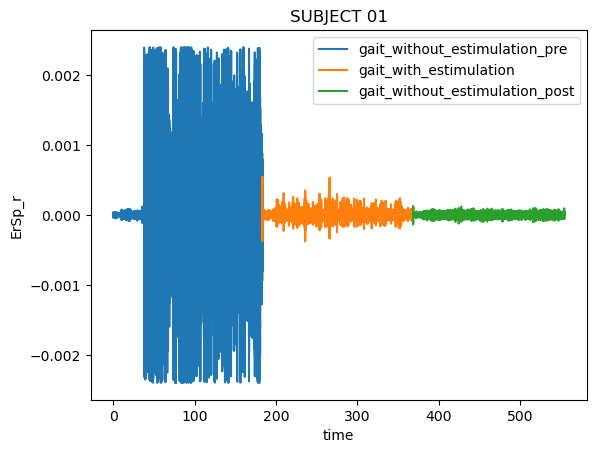

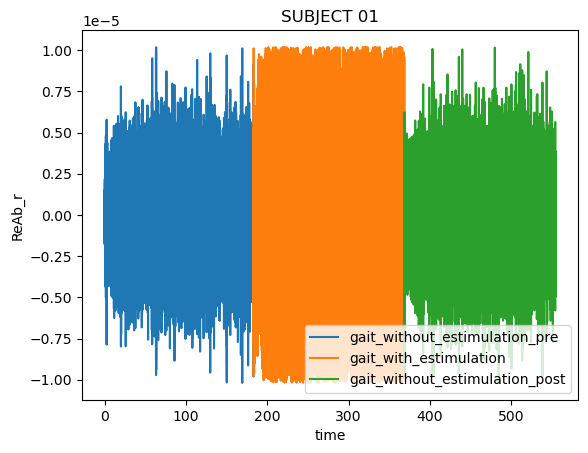

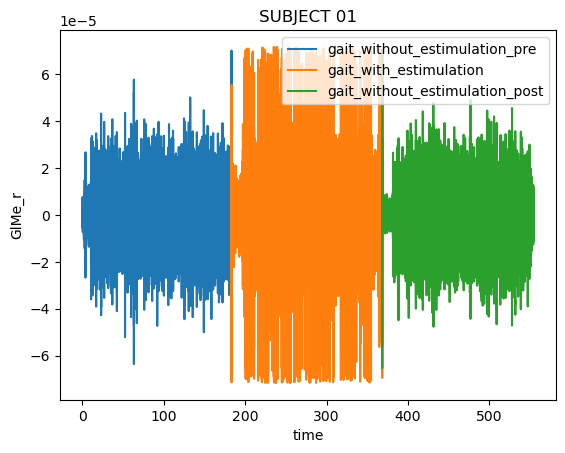

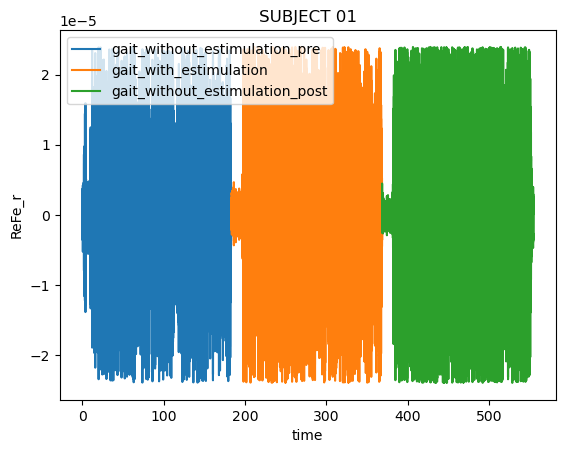

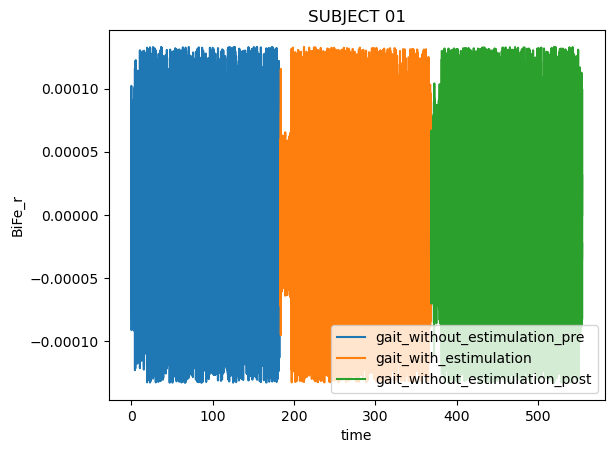

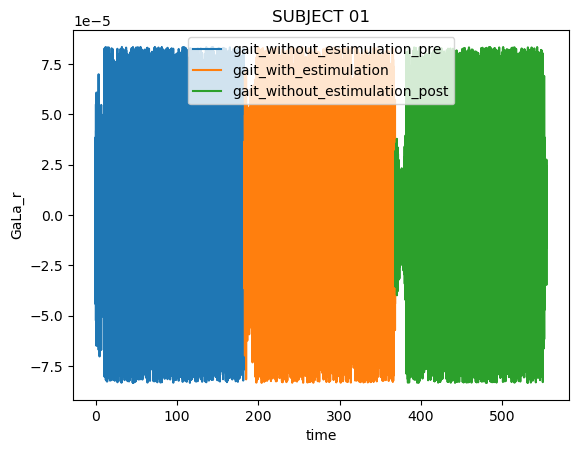

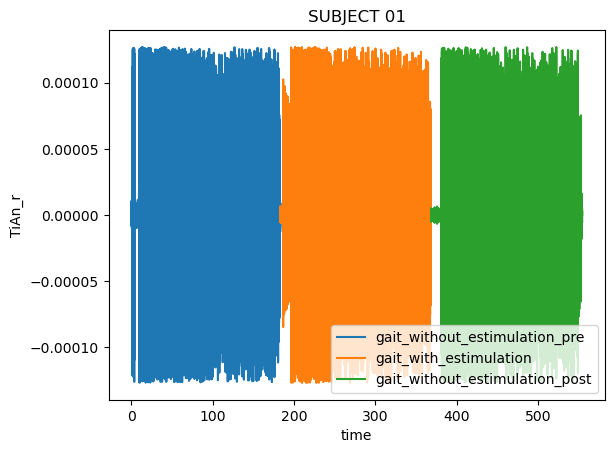

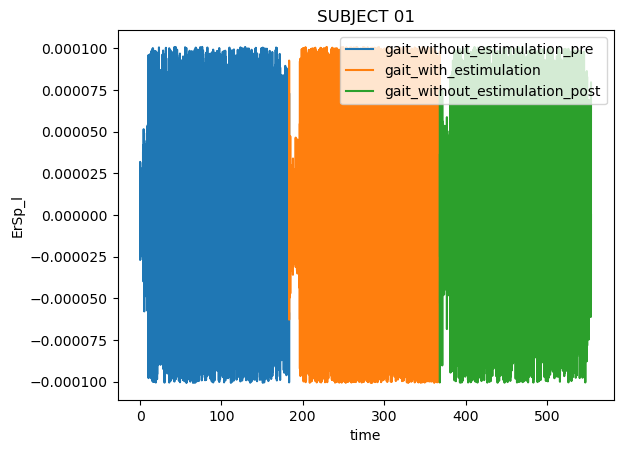

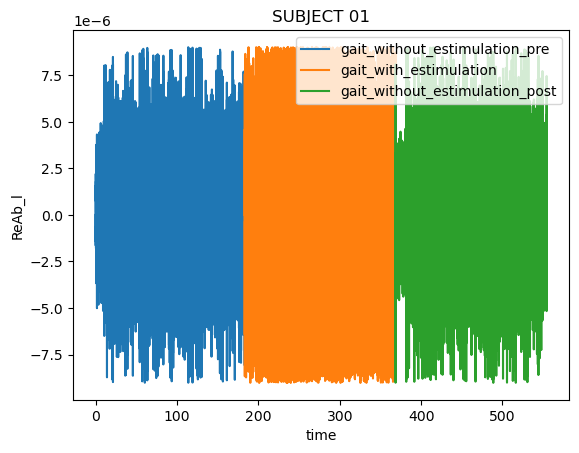

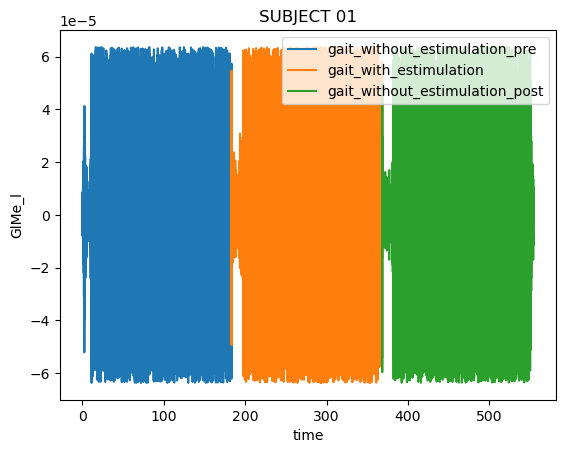

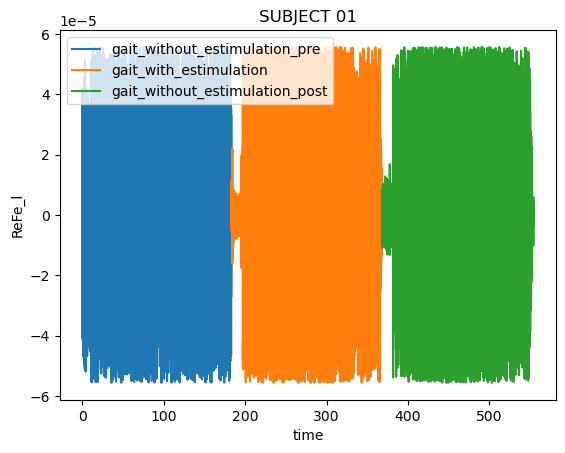

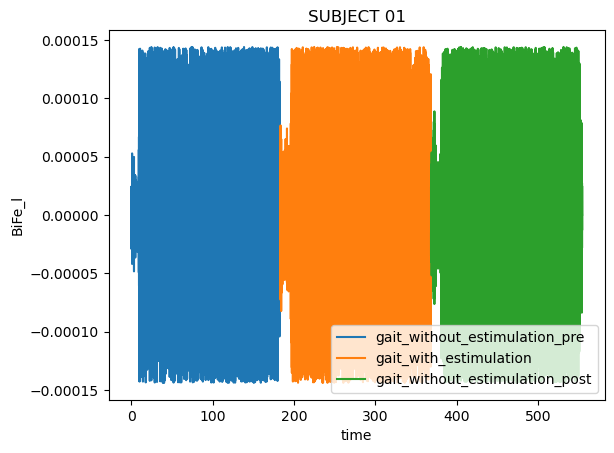

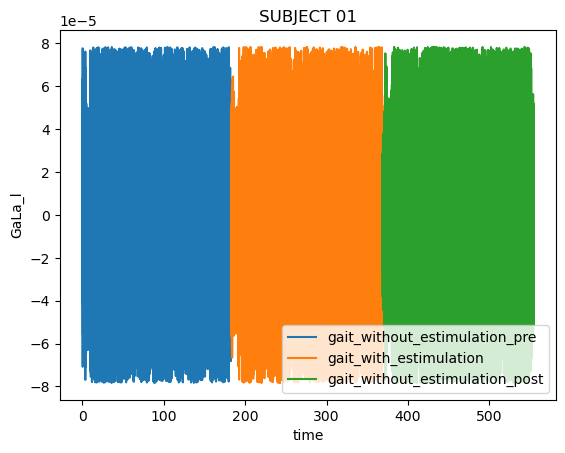

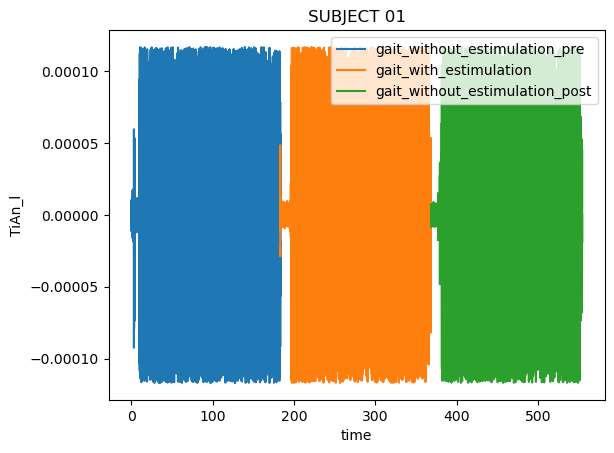

In [76]:
for subject in subjects:
    print('SUBJECT 0' + str(subject))
    list_events_gait = list(path_events.glob('*subject_0' + str(subject) + '*.yaml'))
    with open(list_events_gait[0], 'r') as archivo:
        events_data = yaml.safe_load(archivo)
        
    list_emg_gait = list(path_signal.glob('*subject_0' + str(subject) + '*.csv'))
    emg_gait = pd.read_csv(list_emg_gait[0])
    
    columns_emg = conv.find_unique_cols_csv(list_emg_gait)
    
    dfs = conv.convert_dir_eurobench_to_defaultdict(list_emg_gait, columns=columns_emg, path_events=path_events, split_using_events=True, split_events_category=['gait_without_estimulation_pre','gait_with_estimulation','gait_without_estimulation_post'])
    
    for i, muscle_name in enumerate(emg_gait.columns):
        if muscle_name != 'time':
            fig, ax = plt.subplots()
        
            muscle = emg_gait.loc[:,muscle_name]
            #print(muscle)
            
            for c in range(0,len(dfs)):
                for s in range(0,len(dfs[c][muscle_name]['col'][0])):
                    ax.plot(dfs[c]['time']['col'][0][s], dfs[c][muscle_name]['col'][0][s], label = str(dfs[c][muscle_name]['split_by'][0]))
                    
                    
                    ax.set_xlabel('time')
                    ax.set_ylabel(muscle_name)
                    ax.set_title('SUBJECT 0' + str(subject))
                    ax.legend()
                             
                            

# Plot both filtered and cleaned

SUBJECT 01
Processing file subject_01_cond_01_run_01_EMG.csv
***File /Users/neuralrehabilitationgroup/PycharmProjects/DATA_ExoStim/DATA/gait_without_exo/EUROBENCH/SUBJECT_0X/SESSION_01/IRREGULAR_TERRAIN/EMG/subject_01_Info.yaml not found***
dict_keys(['ErSp_l', 'ReFe_l', 'BiFe_l', 'ReAb_r', 'GaLa_r', 'GaLa_l', 'GlMe_l', 'time', 'ErSp_r', 'TiAn_r', 'ReFe_r', 'ReAb_l', 'TiAn_l', 'GlMe_r', 'BiFe_r'])
Processing file subject_01_cond_01_run_01_cleaned.csv
***File /Users/neuralrehabilitationgroup/PycharmProjects/DATA_ExoStim/DATA/gait_without_exo/EUROBENCH/SUBJECT_0X/SESSION_01/IRREGULAR_TERRAIN/EMG/subject_01_Info.yaml not found***
dict_keys(['ErSp_l', 'ReFe_l', 'BiFe_l', 'ReAb_r', 'GaLa_r', 'GaLa_l', 'GlMe_l', 'time', 'ErSp_r', 'TiAn_r', 'ReFe_r', 'ReAb_l', 'TiAn_l', 'GlMe_r', 'BiFe_r'])


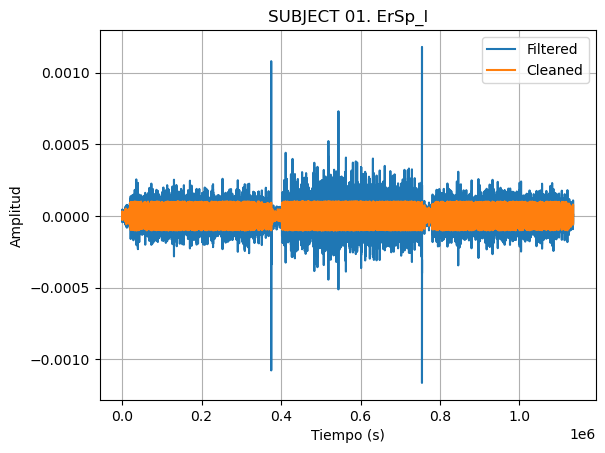

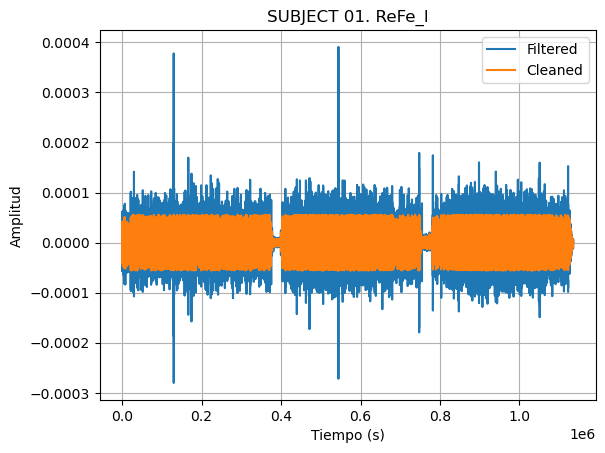

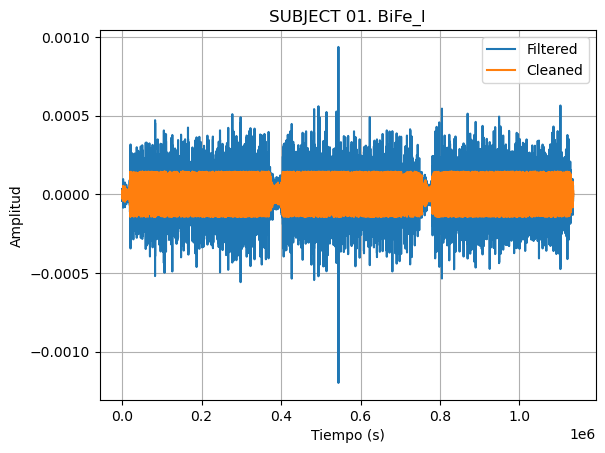

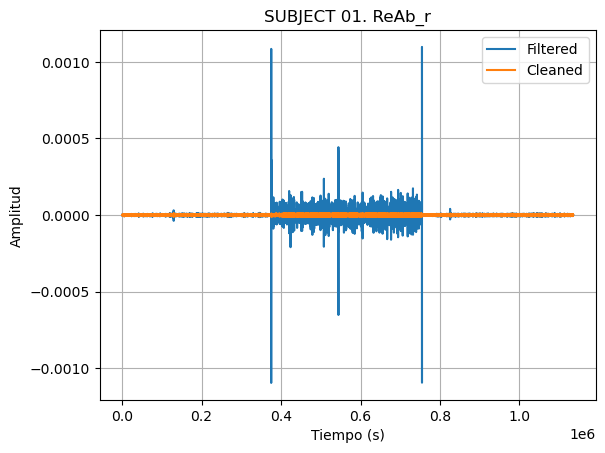

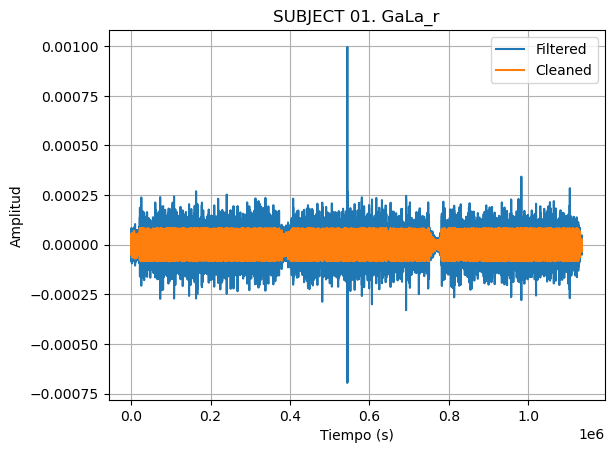

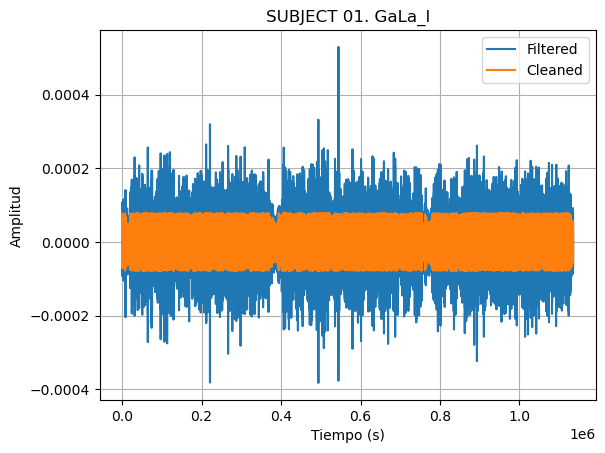

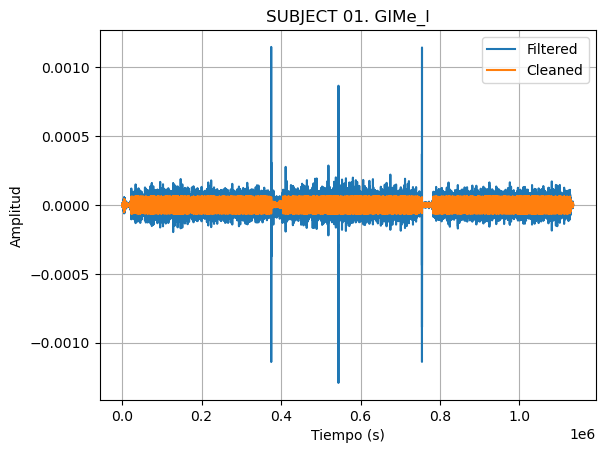

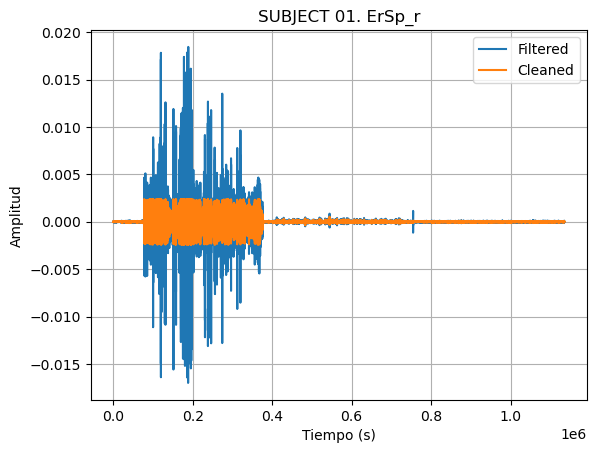

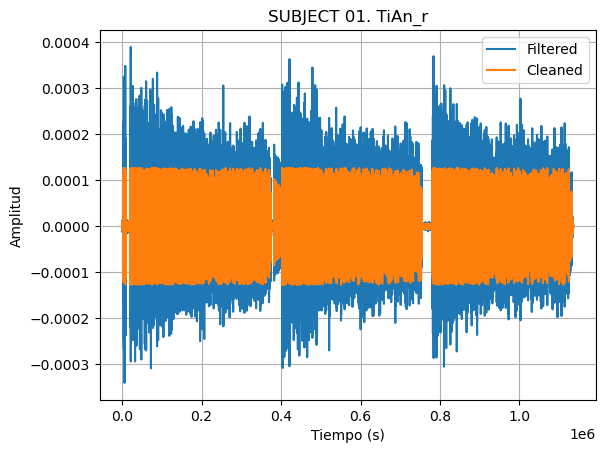

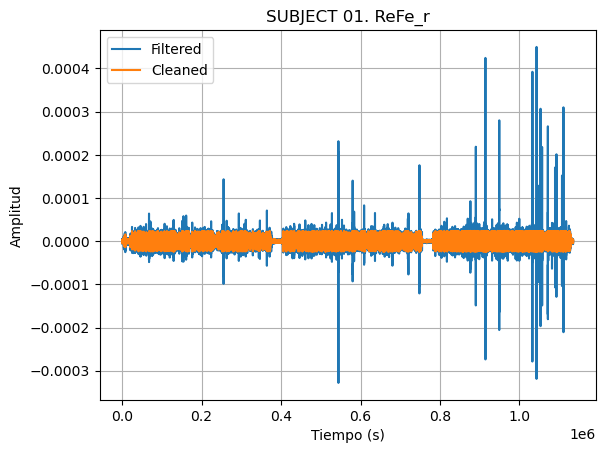

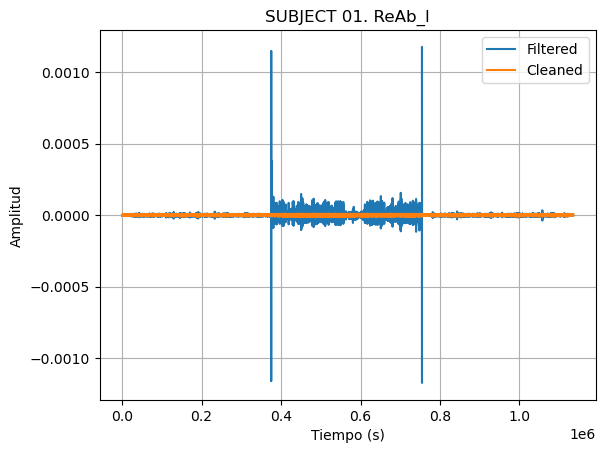

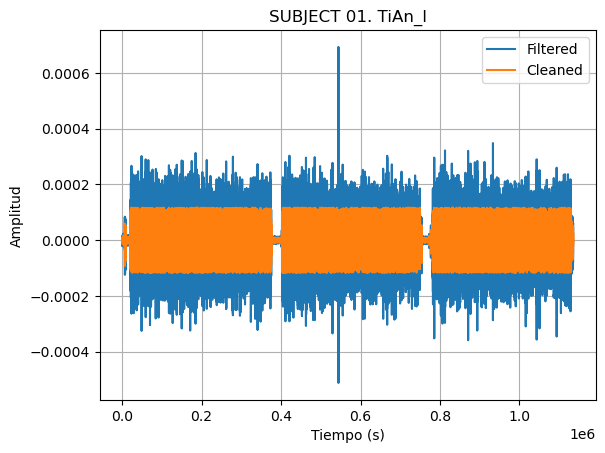

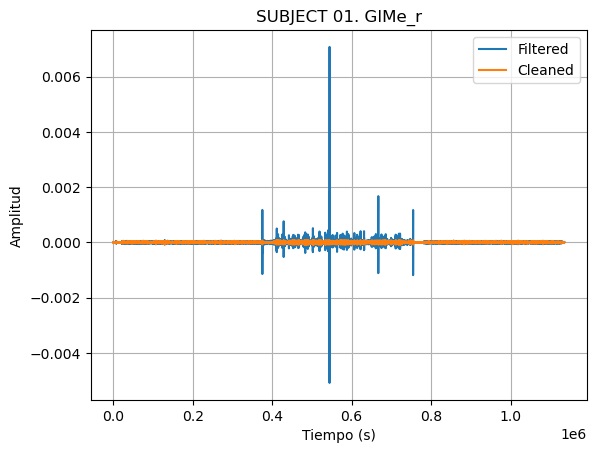

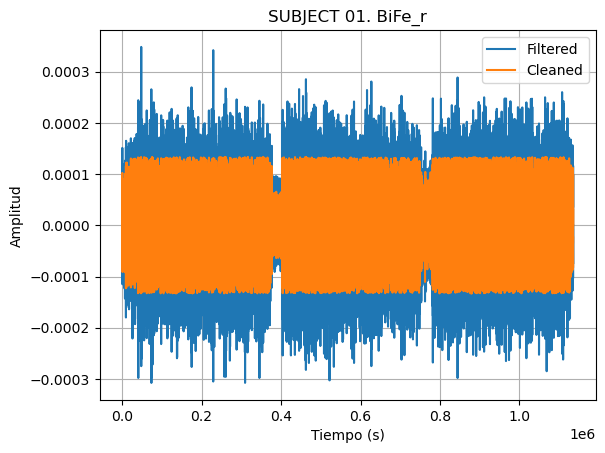

In [56]:
for subject in subjects:
    print('SUBJECT 0' + str(subject))
    list_events_gait = list(path_events.glob('*subject_0' + str(subject) + '*.yaml'))
    with open(list_events_gait[0], 'r') as archivo:
        events_data = yaml.safe_load(archivo)
        
    list_emg_filt = list(path_gait_filt.glob('*subject_0' + str(subject) + '*.csv'))
    
    columns_emg = conv.find_unique_cols_csv(list_emg_filt)
    
    dfs_filt = conv.convert_dir_eurobench_to_defaultdict(list_emg_filt, columns=columns_emg, path_events=path_events, split_using_events=False)
    
    list_emg_clean = list(path_gait_clean.glob('*subject_0' + str(subject) + '*.csv'))
    
    dfs_clean = conv.convert_dir_eurobench_to_defaultdict(list_emg_clean, columns=columns_emg, path_events=path_events, split_using_events=False)
    
    for i, muscle_name in enumerate(columns_emg):
        if muscle_name != 'time':
            fig, ax = plt.subplots() 
            # Plot the original (filtered) and the cleaned signal
            ax.plot(dfs_filt[0][muscle_name]['col'][0], label='Filtered')
            ax.plot(dfs_clean[0][muscle_name]['col'][0], label='Cleaned')
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Amplitud')
            ax.legend()
            ax.set_title('SUBJECT 0' + str(subject) + '. ' + muscle_name)
            ax.grid(True)

# Compute PSD for each part of the trial

In [66]:
def compute_psd_welch(data, sf, muscle, b_plot=False, b_save=False):
    S1, f1 = welch(data, fs=sf, nperseg = 256, window=np.hanning(256), noverlap=128)
    return S1, f1

SUBJECT 03
Processing file subject_03_cond_01_run_01_EMG.csv
***File /Users/neuralrehabilitationgroup/PycharmProjects/DATA_ExoStim/DATA/gait_without_exo/EUROBENCH/SUBJECT_0X/SESSION_01/IRREGULAR_TERRAIN/EMG/subject_03_Info.yaml not found***
dict_keys(['ErSp_l', 'ReFe_l', 'BiFe_l', 'ReAb_r', 'GaLa_r', 'GaLa_l', 'GlMe_l', 'time', 'ErSp_r', 'TiAn_r', 'ReFe_r', 'ReAb_l', 'TiAn_l', 'GlMe_r', 'BiFe_r'])
Processing file subject_03_cond_01_run_01_EMG.csv
***File /Users/neuralrehabilitationgroup/PycharmProjects/DATA_ExoStim/DATA/gait_without_exo/EUROBENCH/SUBJECT_0X/SESSION_01/IRREGULAR_TERRAIN/EMG/subject_03_Info.yaml not found***
dict_keys(['ErSp_l', 'ReFe_l', 'BiFe_l', 'ReAb_r', 'GaLa_r', 'GaLa_l', 'GlMe_l', 'time', 'ErSp_r', 'TiAn_r', 'ReFe_r', 'ReAb_l', 'TiAn_l', 'GlMe_r', 'BiFe_r'])
Processing file subject_03_cond_01_run_01_EMG.csv
***File /Users/neuralrehabilitationgroup/PycharmProjects/DATA_ExoStim/DATA/gait_without_exo/EUROBENCH/SUBJECT_0X/SESSION_01/IRREGULAR_TERRAIN/EMG/subject_03_In

/var/folders/63/2lz089h509ddd045_5prskfm0000gn/T/ipykernel_12328/680637087.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


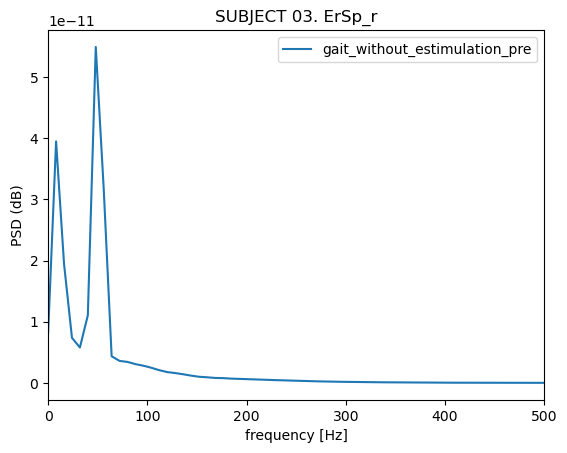

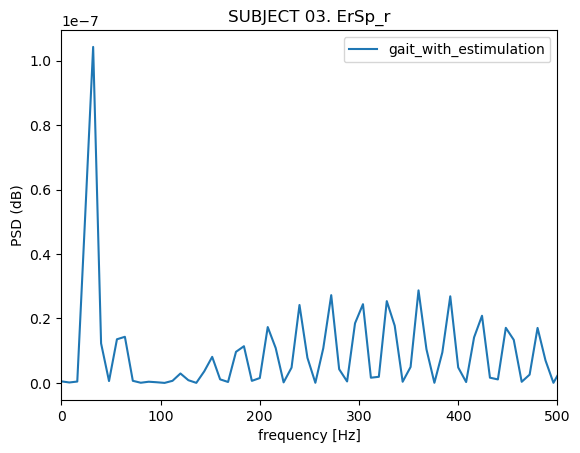

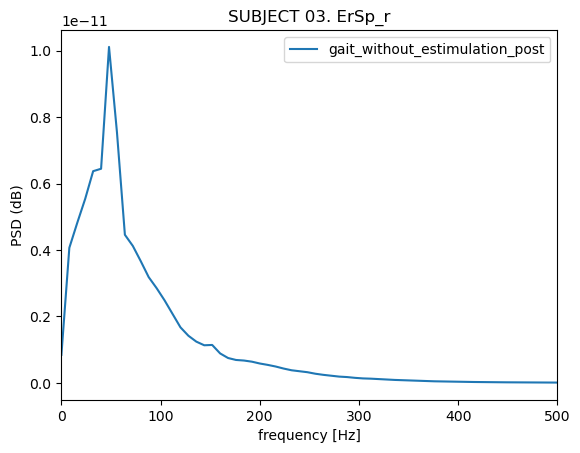

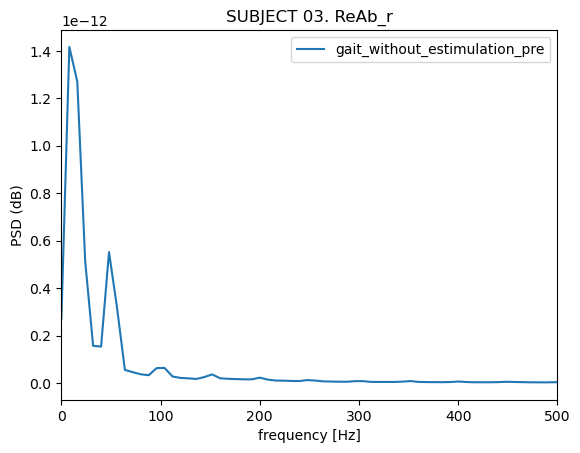

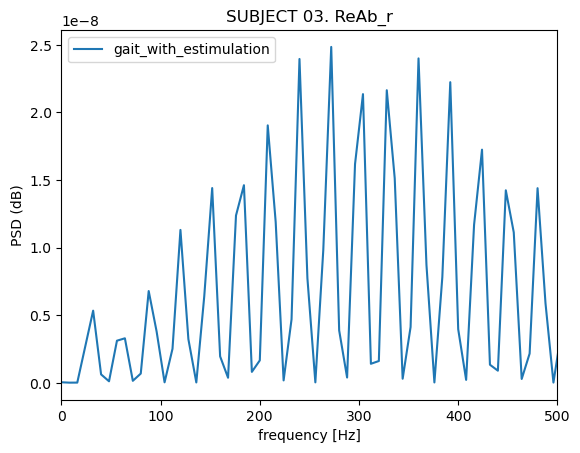

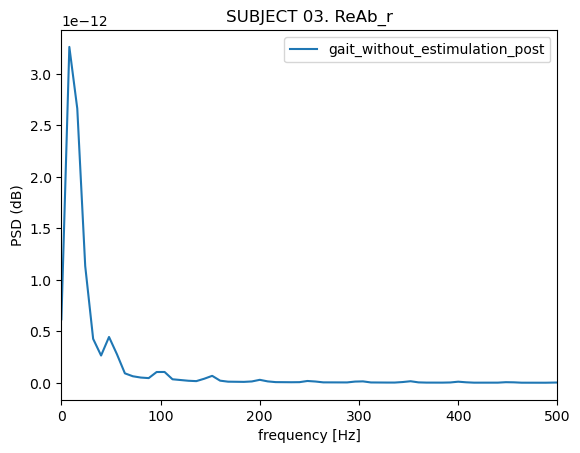

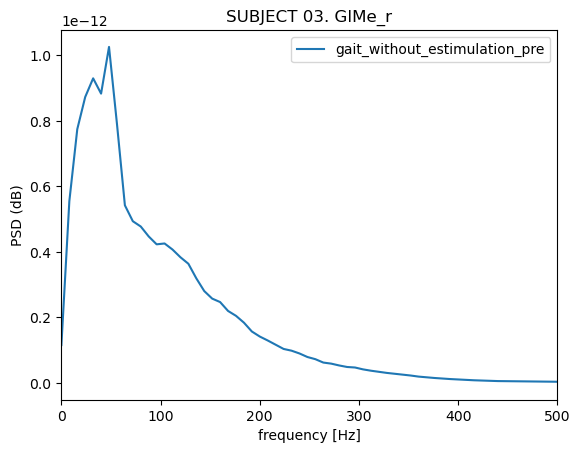

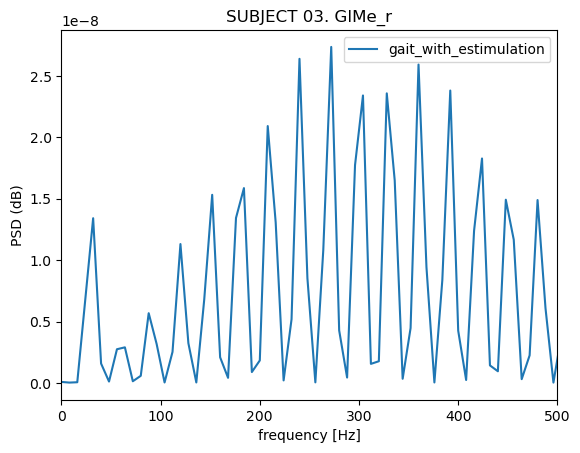

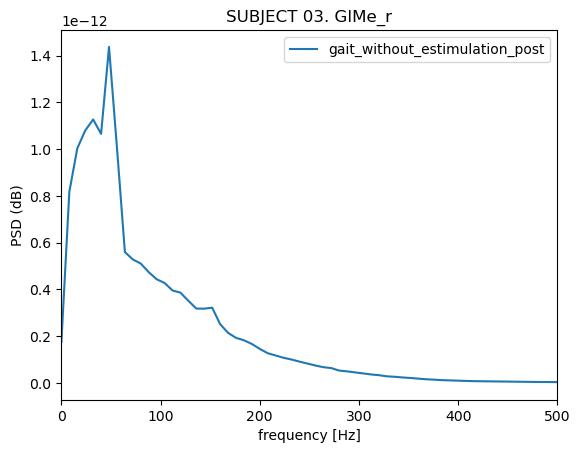

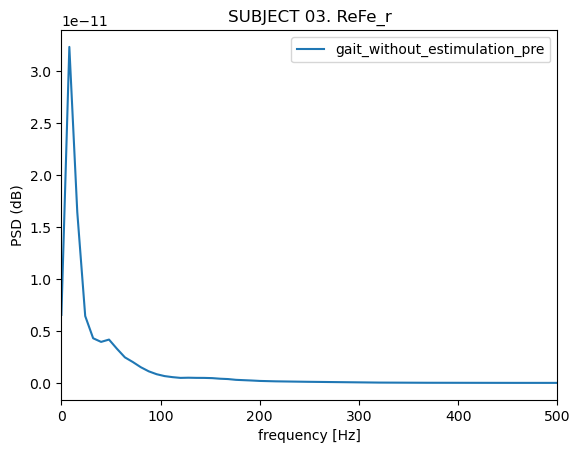

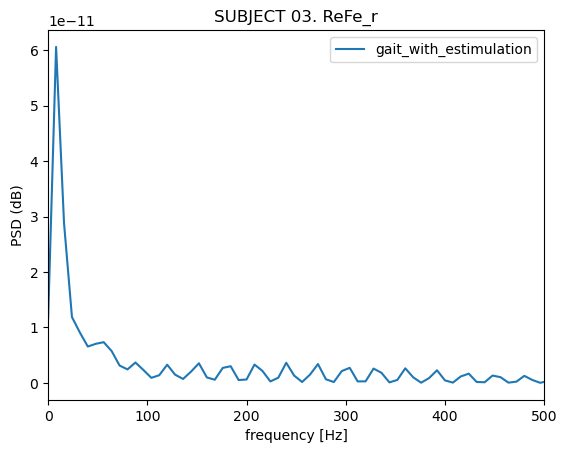

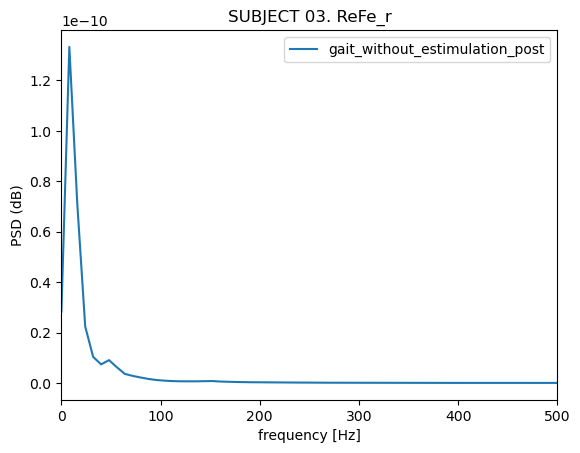

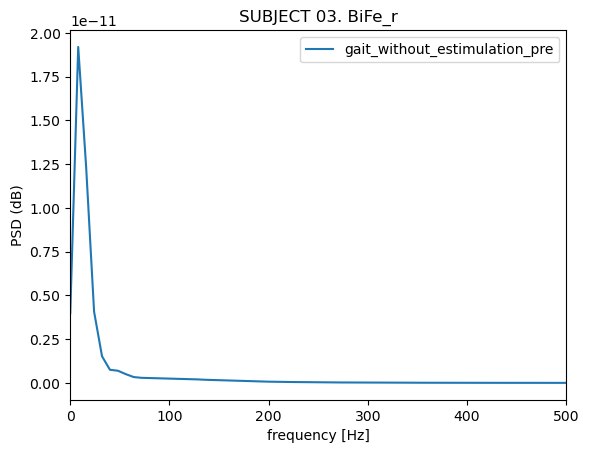

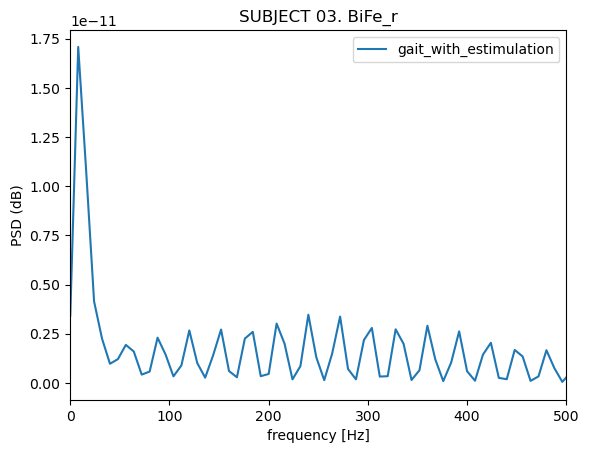

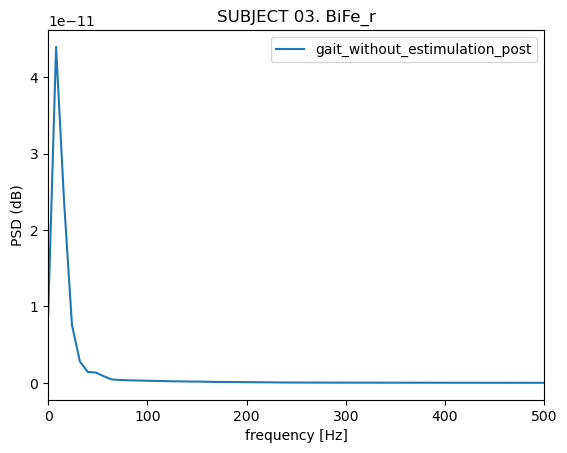

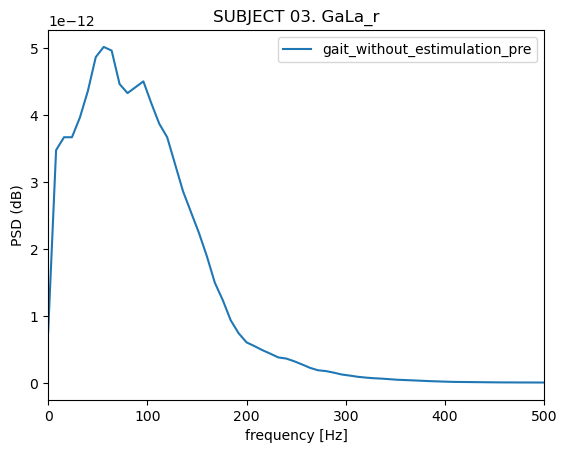

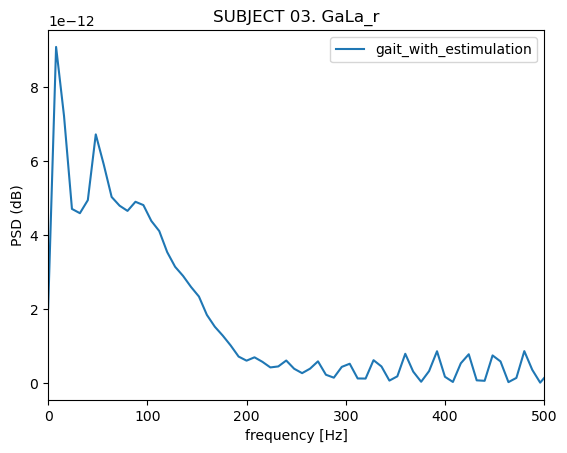

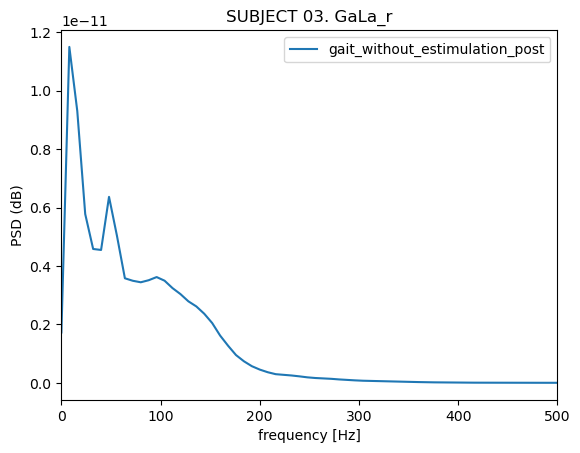

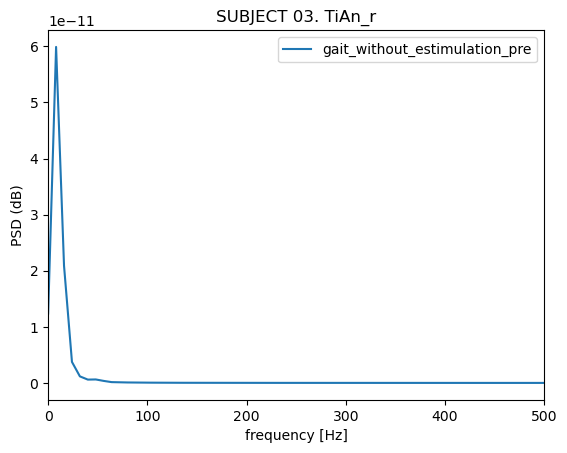

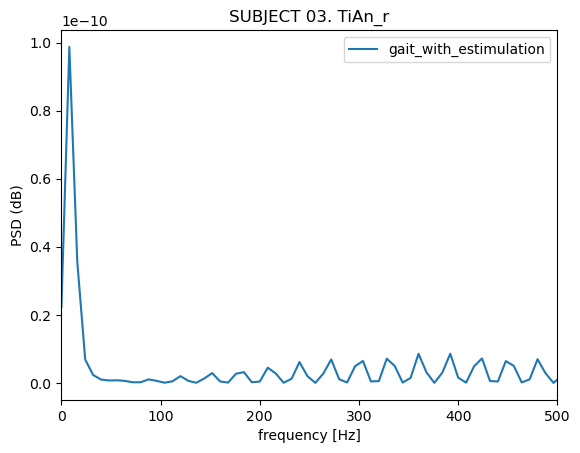

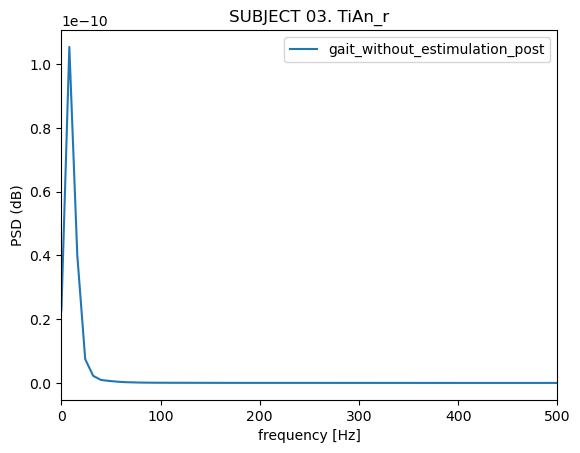

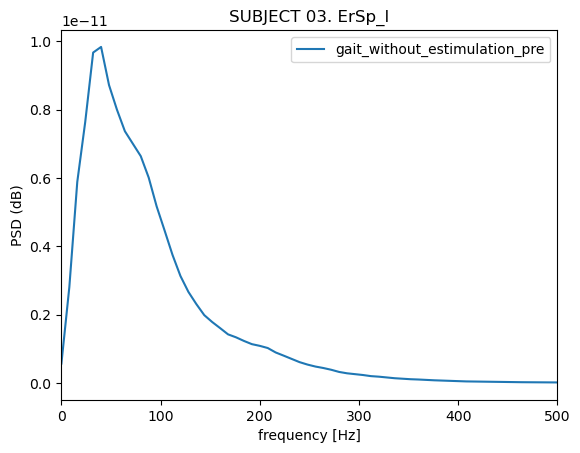

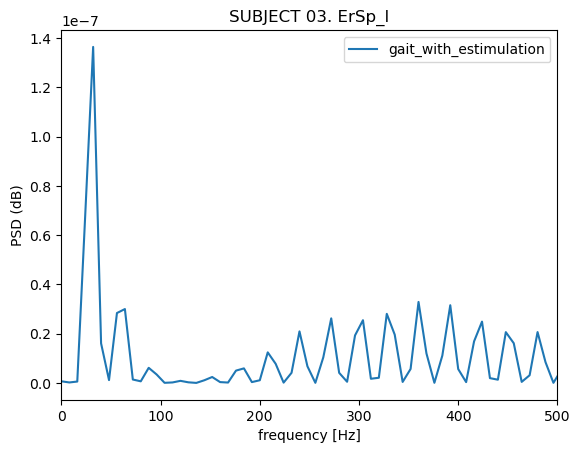

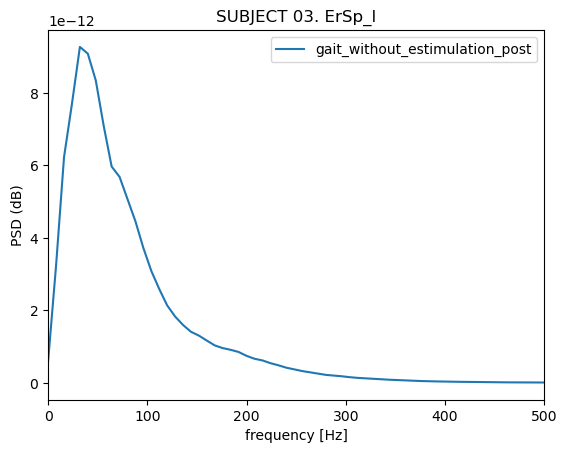

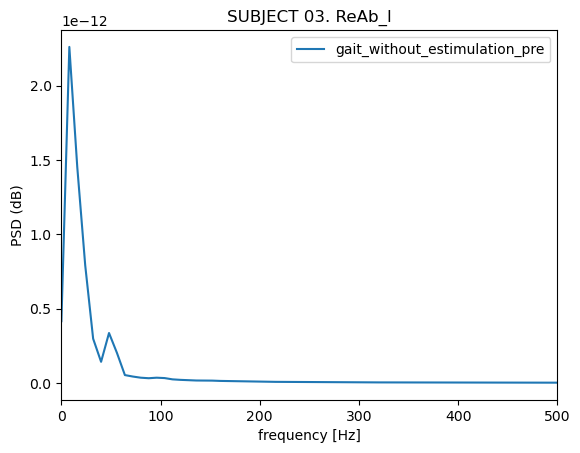

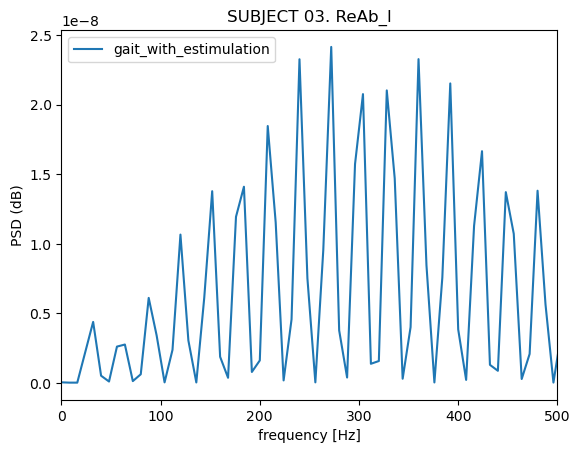

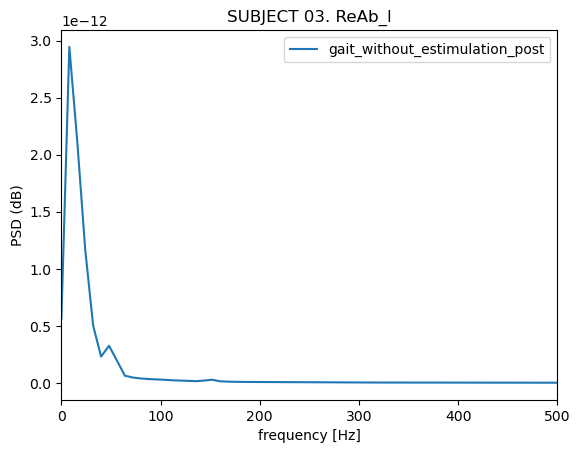

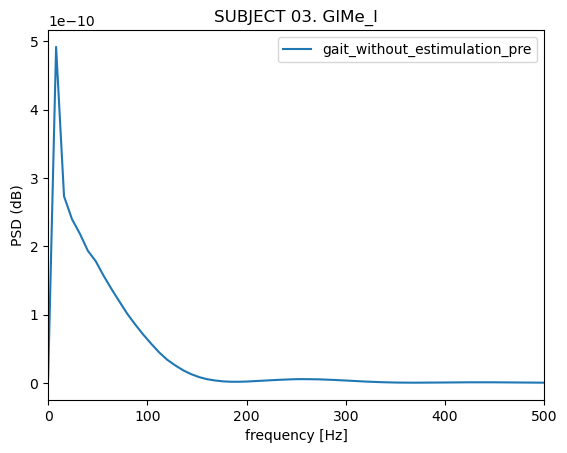

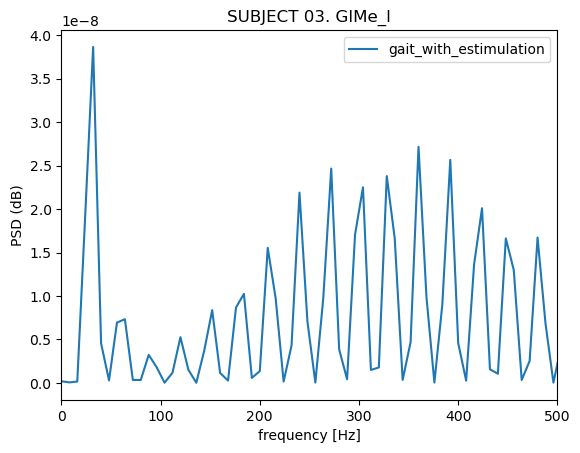

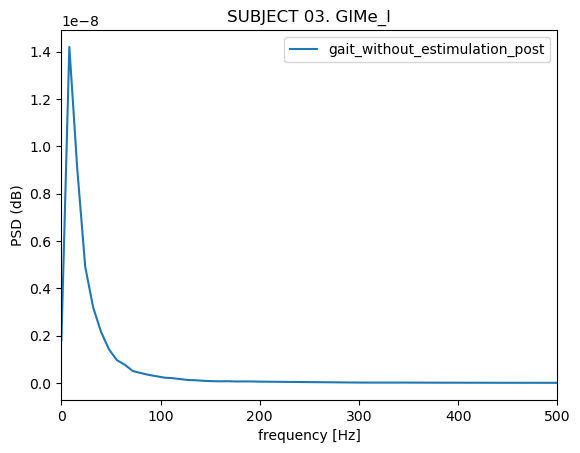

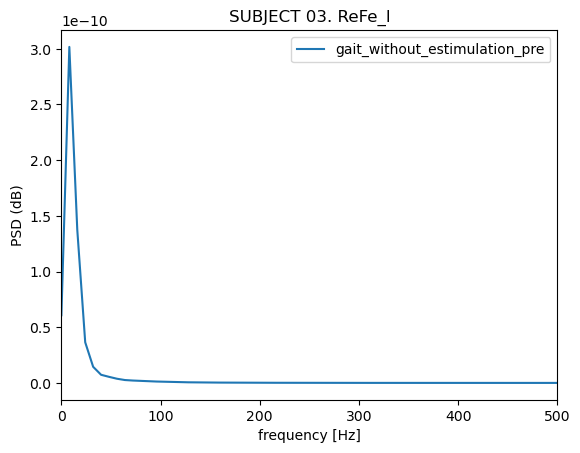

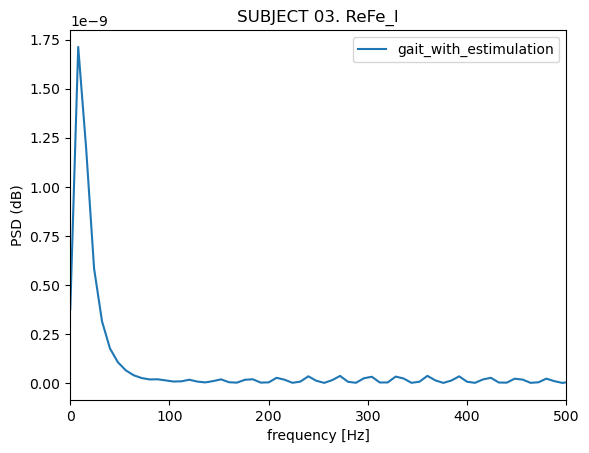

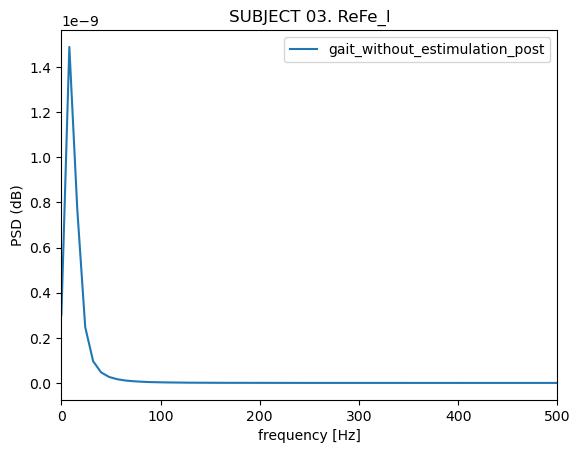

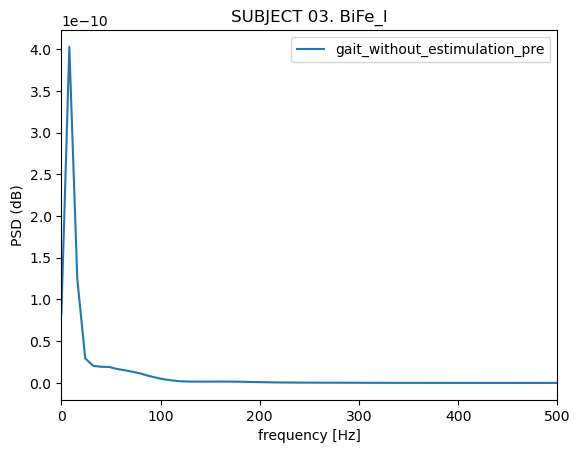

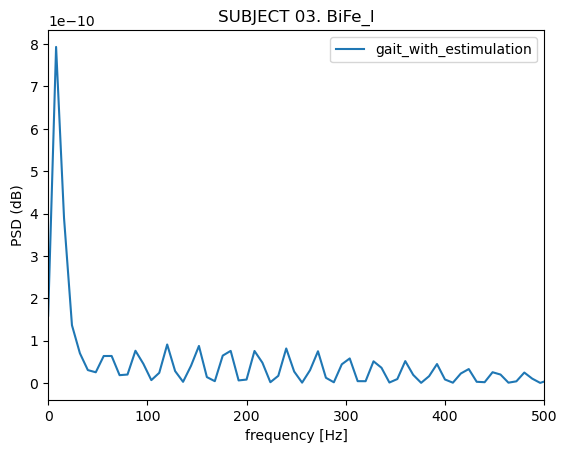

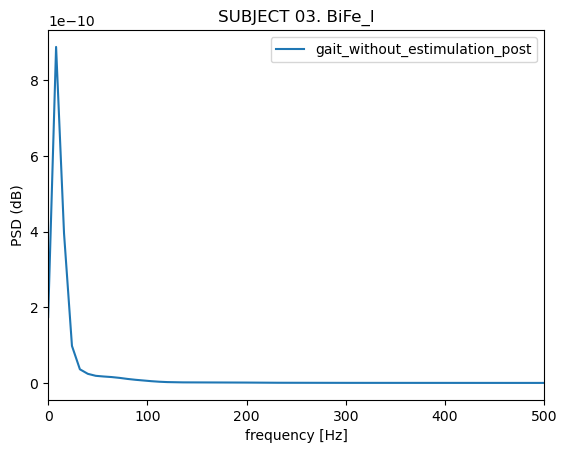

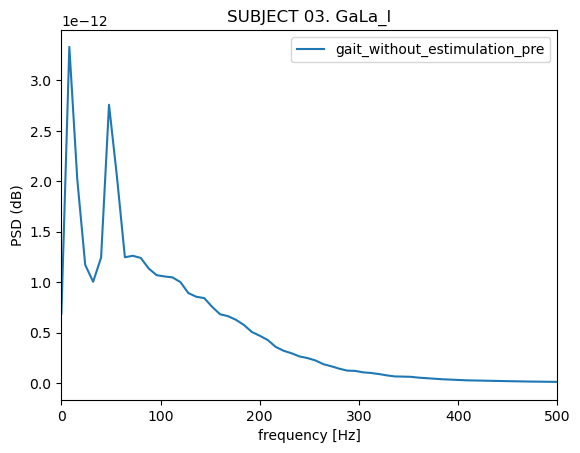

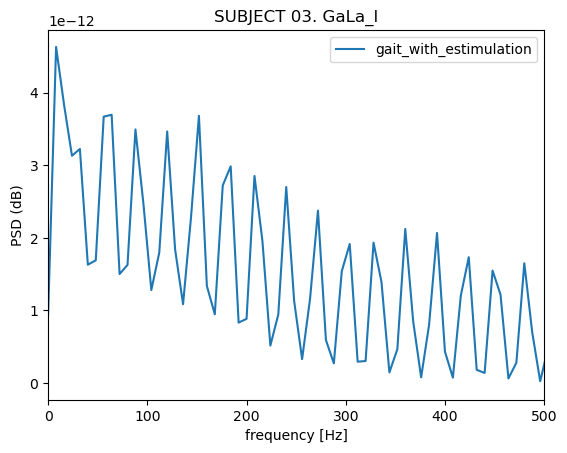

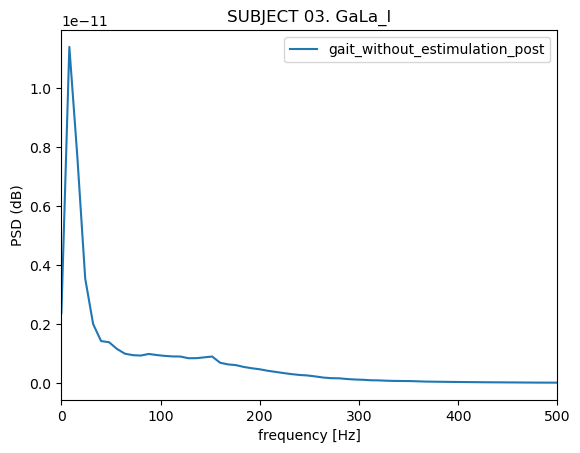

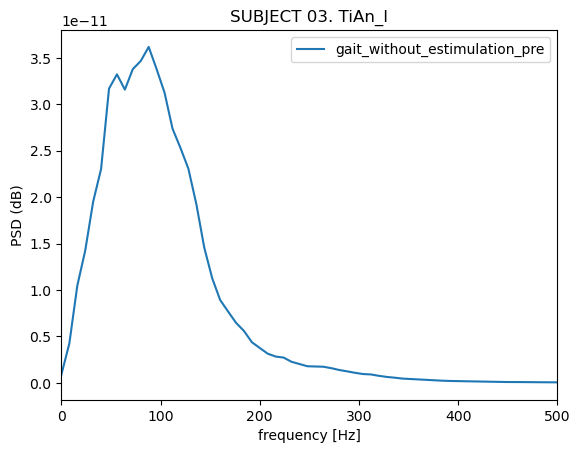

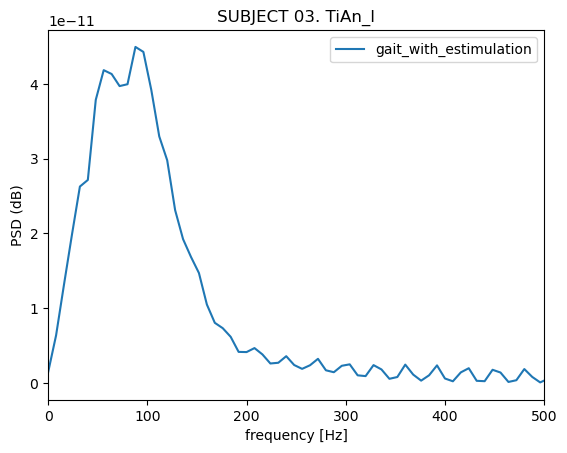

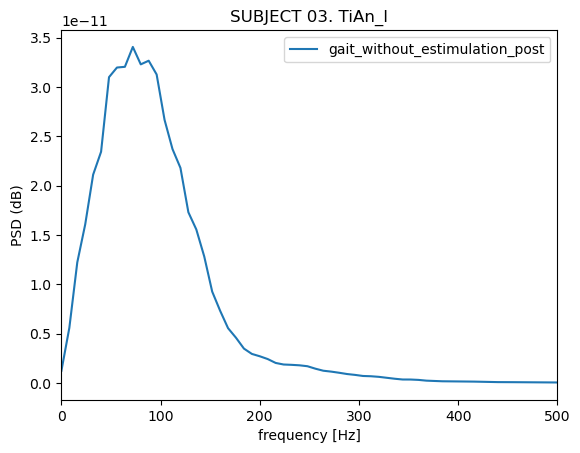

In [70]:
for subject in subjects:
    print('SUBJECT 0' + str(subject))
    list_events_gait = list(path_events.glob('*subject_0' + str(subject) + '*.yaml'))
    with open(list_events_gait[0], 'r') as archivo:
        events_data = yaml.safe_load(archivo)
        
    list_emg_gait = list(path_signal.glob('*subject_0' + str(subject) + '*.csv'))
    emg_gait = pd.read_csv(list_emg_gait[0])
    
    columns_emg = conv.find_unique_cols_csv(list_emg_gait)
    
    dfs = conv.convert_dir_eurobench_to_defaultdict(list_emg_gait, columns=columns_emg, path_events=path_events, split_using_events=True, split_events_category=['gait_without_estimulation_pre','gait_with_estimulation','gait_without_estimulation_post'])
    
    for i, muscle_name in enumerate(emg_gait.columns):
        if muscle_name != 'time':
            for c in range(0,len(dfs)): 
                fig, ax = plt.subplots()
                for s in range(0,len(dfs[c][muscle_name]['col'][0])):
                    f1, S1 = compute_psd_welch(dfs[c][muscle_name]['col'][0][s], sf, muscle_name, b_plot=False, b_save=False)
                    #S1, f1 = plt.psd(dfs[c][muscle_name]['col'][0][s], NFFT=256, Fs=sf, window=np.hanning(256), noverlap=128, label=str(dfs[c][muscle_name]['split_by'][0]))
                    # plt.close()
                    ax.plot(f1, S1, label=str(dfs[c][muscle_name]['split_by'][0]))
                    ax.set(title= 'SUBJECT 0' + str(subject) + '. ' + muscle_name, xlabel = 'frequency [Hz]', ylabel = 'PSD (dB)')
                    ax.legend()
                    ax.set_xlim(0,500)
                    
